<a href="https://colab.research.google.com/github/KOdunga/MITIDSS/blob/main/PredictingRetailSpending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicting Retail Spending with Automated Feature Engineering in Feature tools**

- Time and feature creation capabilities of feature tools function.

In [1]:
!pip install featuretools==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327 kB 8.5 MB/s 
     |████████████████████████████████| 291 kB 45.7 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

import featuretools as ft

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_excel('/content/drive/MyDrive/DSML/Online Retail.xlsx')

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
data.shape

(541909, 8)

In [7]:
#Convert pounds to dollars
data['UnitPrice']=data['UnitPrice']*1.65
data['total'] = data['UnitPrice'] * data['Quantity']

In [8]:
#Restrict to only 2011 data
data_2011 = data[data['InvoiceDate'].dt.year== 2011]

In [9]:
data_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625


In [10]:
data_2011.shape

(499428, 9)

In [11]:
data_2011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499428 entries, 42481 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    499428 non-null  object        
 1   StockCode    499428 non-null  object        
 2   Description  498099 non-null  object        
 3   Quantity     499428 non-null  int64         
 4   InvoiceDate  499428 non-null  datetime64[ns]
 5   UnitPrice    499428 non-null  float64       
 6   CustomerID   379979 non-null  float64       
 7   Country      499428 non-null  object        
 8   total        499428 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 38.1+ MB


In [12]:
#Drop duplicated rows
data_2011.duplicated().sum()

4768

- There as 4,768 rows that are of duplicate values. We drop these as they will add bias in the dataset.

In [13]:
data_2011.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1329
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     119449
Country             0
total               0
dtype: int64

- We can fill the null customer id values by matching the invoice numbers, but for this exercise, we will opt to drop these.

In [14]:
#Drop the duplicates
data_2011 = data_2011.drop_duplicates()

#Drop rows with null customer id values
data_2011 = data_2011.dropna(axis = 0)

data_2011['cancelled'] = data_2011['InvoiceNo'].str.startswith('C', na = False)

In [15]:
data_2011.shape

(375250, 10)

In [16]:
data_2011[data_2011.cancelled == True].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
42557,C540006,21306,SET/4 DAISY MIRROR MAGNETS,-1,2011-01-04 10:48:00,3.4650,14606.0,United Kingdom,-3.4650,True
42558,C540006,84352,SILVER CHRISTMAS TREE BAUBLE STAND,-1,2011-01-04 10:48:00,27.9675,14606.0,United Kingdom,-27.9675,True
42559,C540006,22423,REGENCY CAKESTAND 3 TIER,-1,2011-01-04 10:48:00,21.0375,14606.0,United Kingdom,-21.0375,True
42560,C540007,21055,TOOL BOX SOFT TOY,-6,2011-01-04 11:08:00,14.7675,15379.0,United Kingdom,-88.6050,True
42561,C540007,22274,FELTCRAFT DOLL EMILY,-6,2011-01-04 11:08:00,4.8675,15379.0,United Kingdom,-29.2050,True


In [17]:
data_2011['cancelled'].value_counts(normalize = True)

False    0.978172
True     0.021828
Name: cancelled, dtype: float64

-There are about 2% invoices that were cancelled

In [18]:
data_2011.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,375250.0,12.252296,258.180877,-80995.00,2.0000,5.0000,12.0000,80995.00
UnitPrice,375250.0,5.762031,119.054102,0.00,2.0625,3.2175,6.1875,64300.50
CustomerID,375250.0,15265.136168,1710.927381,12346.00,13901.0000,15108.0000,16767.0000,18287.00
total,375250.0,33.972397,733.803756,-277974.84,7.0125,19.3050,32.6700,277974.84


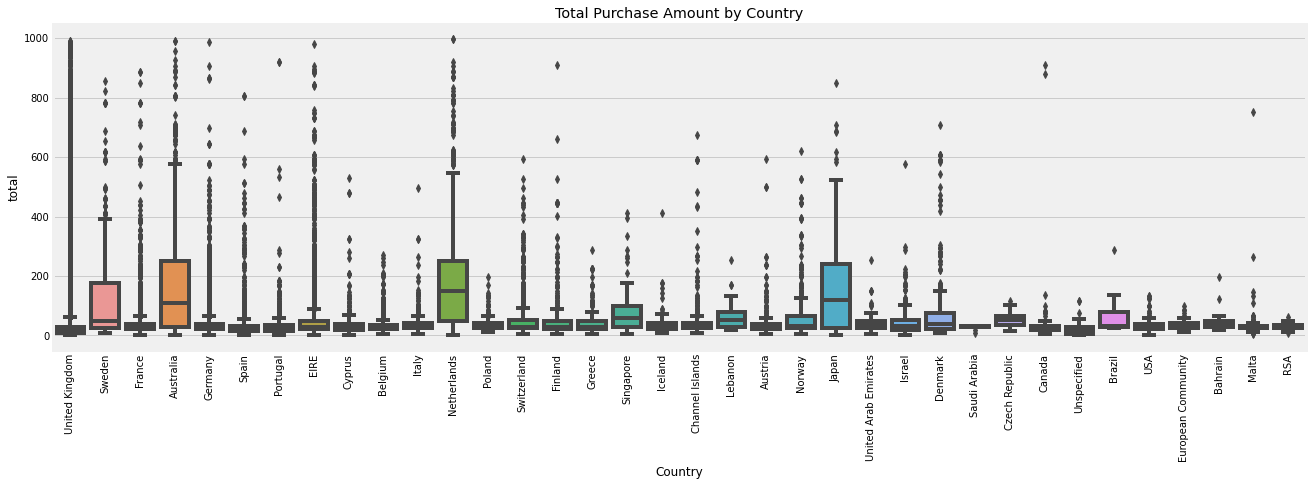

In [19]:
#Plot boxplot to see distribution of purchases per country
plt.figure(figsize = (20,6))
sns.boxplot(x = 'Country', y = 'total', data = data_2011[(data_2011['total']>0)&(data_2011['total']<1000)])
plt.title('Total Purchase Amount by Country')
plt.xticks(rotation = 90)
plt.show()

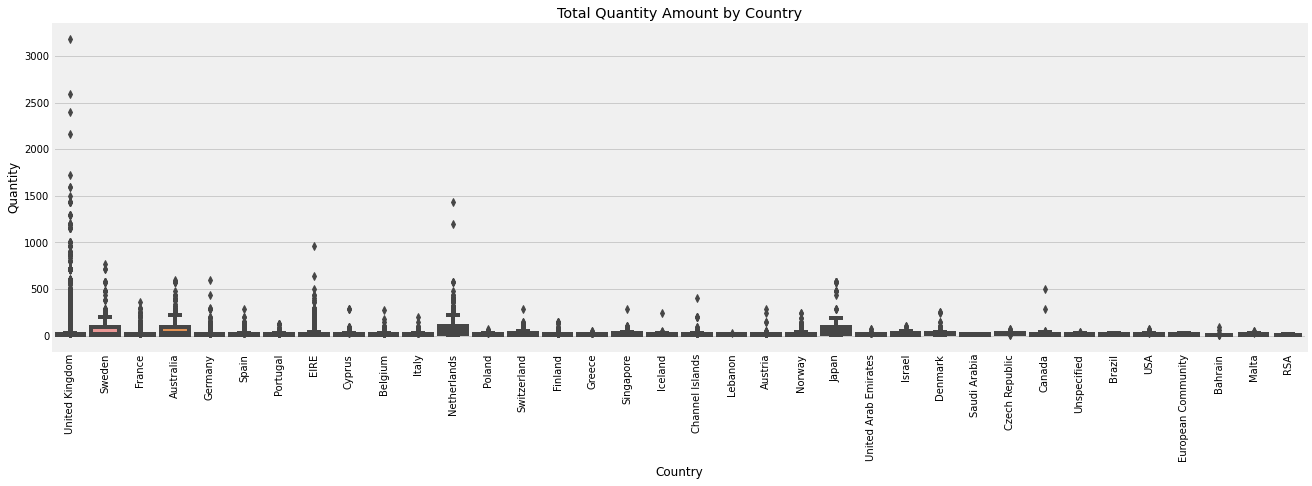

In [20]:
#Plot boxplot to see distribution of purchases per country
plt.figure(figsize = (20,6))
sns.boxplot(x = 'Country', y = 'Quantity', data = data_2011[(data_2011['total']>0)&(data_2011['total']<1000)])
plt.title('Total Quantity Amount by Country')
plt.xticks(rotation = 90)
plt.show()

- Both purchase price and quantity are heavily skewed due to extreme outliers. This means it might be difficult to perfoam a regression problem on the dataset.
- We therefore might want to frame the problem as classificationbecause the large purchase totals could throw off a machine learning algorithm. Our other option would be to remove the outliers but since these are market legitimate outliers, we cannot just remove them.

In [21]:
#We use an empirical cummulative distribtuin function(ecdf) plot to see the skewness of the data

def ecdf(data_2011):
  x = np.sort(data_2011)
  y = np.arange(1,len(x) + 1)/len(x)
  return x,y

Text(0.5, 1.0, 'ECDF of Purchase Quantity')

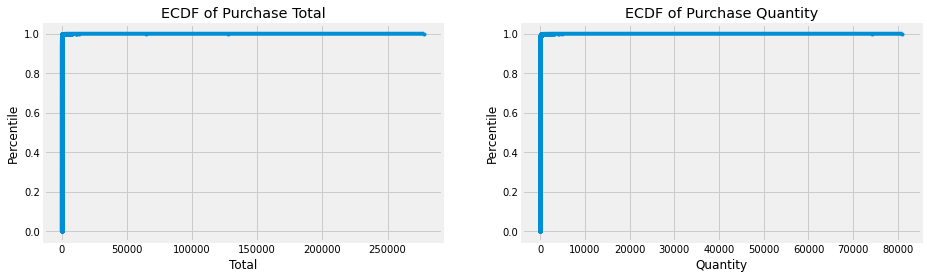

In [22]:
plt.figure(figsize = (14,4))

#Total
plt.subplot(121)
x,y = ecdf(data_2011.loc[data_2011['total']>0,'total'])
plt.plot(x,y,marker = '.')
plt.xlabel('Total'); plt.ylabel('Percentile');plt.title('ECDF of Purchase Total')

#Quantity
plt.subplot(122)
x,y = ecdf(data_2011.loc[data_2011['total']>0,'Quantity'])
plt.plot(x,y,marker = '.')
plt.xlabel('Quantity'); plt.ylabel('Percentile');plt.title('ECDF of Purchase Quantity')

- A majority of purchases are below $20 but there are a number of outliers. 
- Rather than using a regression problem, we therefore moght want to try classifying customers based on their spending per month.

## **Prediction Problem**

**Predict whether or not a customer will spend more than $500 in the next month.** This can help a business market more effectively targeting clients who are likely to spend more.

In [23]:
#Generating Labels that are dependent on customer spend > $500 within the 30 days monthly period

data_2011.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total', 'cancelled'],
      dtype='object')

In [24]:
def make_retail_cutoffs_total(start_date, end_date, threshold = 500):
  
  #find customers who exist before start date
  customer_pool = data_2011[data_2011['InvoiceDate']< start_date]['CustomerID'].unique()
  tmp = pd.DataFrame({'CustomerID': customer_pool})

  #For customers in the customer pool, find their sum between the start and end dates
  totals = data_2011[data_2011['CustomerID'].isin(customer_pool)&
                     (data_2011['InvoiceDate']> start_date)&
                     (data_2011['InvoiceDate']<end_date)
                     ].groupby('CustomerID')['total'].sum().reset_index()
  
  #Merge with all the customer ids to record all customers who existed before start date
  totals = totals.merge(tmp, on = 'CustomerID', how = 'right')

  #Set the total for any customer who didnot have a purchase in the timeframe equal to 0
  totals['total'] = totals['total'].fillna(0)

  #label is based on the threshold
  totals['label'] = (totals['total']>threshold).astype(int)

  #The cutoff time is the start date
  totals['cutoff_time'] = pd.to_datetime(start_date)
  totals = totals[['CustomerID', 'cutoff_time','total','label']]

  return totals
          

In [25]:
may_spending = make_retail_cutoffs_total(pd.datetime(2011,5,1), pd.datetime(2011,6,1))
may_spending.head(10)

,CustomerID,cutoff_time,total,label
0,13313.0,2011-05-01,499.0260,0
1,18097.0,2011-05-01,1318.9770,1
2,16656.0,2011-05-01,1804.1760,1
3,16875.0,2011-05-01,0.0000,0
4,13094.0,2011-05-01,678.9420,1
5,17315.0,2011-05-01,873.2955,1
6,14606.0,2011-05-01,1095.7485,1
7,15379.0,2011-05-01,345.1470,0
8,16255.0,2011-05-01,0.0000,0
9,13319.0,2011-05-01,1187.1255,1


- The label is based on our threshold of $500 and the cutoff time represents the point at which any date we use must lie before to avoid data leakage.
- For each customer in the data before May we have created a lable for the month of May which is the sum of their spending in May converted to a binary label.
- When we make features for these labels, we can only use data from before May.

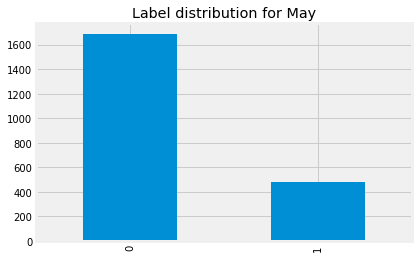

In [26]:
may_spending['label'].value_counts().plot.bar()
plt.title('Label distribution for May'); plt.show()

In [27]:
may_spending['label'].value_counts()

0    1689
1     483
Name: label, dtype: int64

- This is an **imbalanced** classification problem which means that we probably dont want to useaccuracy as our metric.

##Metrics
1. Precision - Percentage of customers predicted to spend more than $500 that actually did
2. Recall - Percentage of customers that actually sepnt more than 500 that were correctly identified
3. F1 Score - Harmonic mean of precision and recall
4. ROC AUC - Receiver Operating Characteristics Area Under the Curve. a 0 to 1 measure, with 1 being optimal that measures the perfomance of a model across a range of thresholds 

In [28]:
#We now make labels for each month
march_spending = make_retail_cutoffs_total('2011-03-01','2011-04-01',500)
april_spending = make_retail_cutoffs_total('2011-04-01','2011-05-01',500)
june_spending = make_retail_cutoffs_total('2011-06-01','2011-07-01',500)
july_spending = make_retail_cutoffs_total('2011-07-01','2011-08-01',500)
august_spending = make_retail_cutoffs_total('2011-08-01','2011-09-01',500)
september_spending = make_retail_cutoffs_total('2011-09-01','2011-10-01',500)
october_spending = make_retail_cutoffs_total('2011-10-01','2011-11-01',500)
november_spending = make_retail_cutoffs_total('2011-11-01','2011-12-01',500)
december_spending = make_retail_cutoffs_total('2011-12-01','2012-01-01',500)

In [29]:
labels = pd.concat([march_spending,april_spending,may_spending,june_spending,july_spending,august_spending,september_spending,october_spending,november_spending,december_spending], axis = 0)

print(labels.shape)
labels.label.value_counts(normalize = True)

(28133, 4)


0    0.829453
1    0.170547
Name: label, dtype: float64

- We have roughly 28K labels with 17% of them being positive.

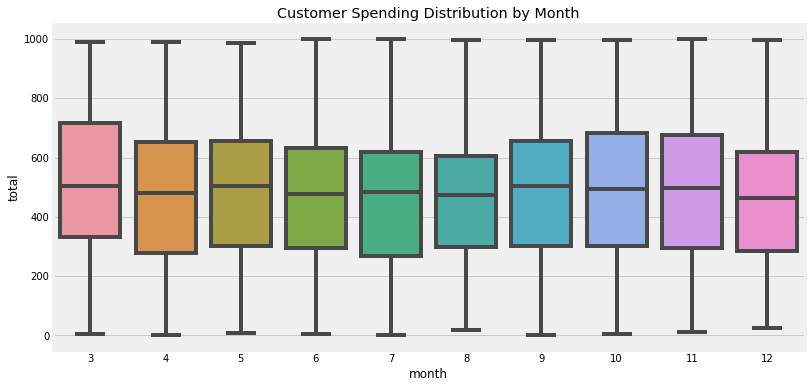

In [30]:
#Examine the data by plotting the total spending distribution by month (with negative totals removed)
plot_labels = labels.copy()
plot_labels['month'] = plot_labels['cutoff_time'].dt.month

plt.figure(figsize=(12,6))
sns.boxplot(x = 'month', y = 'total', data = plot_labels[(plot_labels['total']>0) & (plot_labels['total']<1000)])
plt.title('Customer Spending Distribution by Month')
plt.show()

In [31]:
labels.loc[labels['CustomerID'] == 12347]

,CustomerID,cutoff_time,total,label
666,12347.0,2011-03-01,0.0000,0
666,12347.0,2011-04-01,1049.8125,1
666,12347.0,2011-05-01,0.0000,0
666,12347.0,2011-06-01,631.1580,1
666,12347.0,2011-07-01,0.0000,0
666,12347.0,2011-08-01,965.1015,1
666,12347.0,2011-09-01,0.0000,0
666,12347.0,2011-10-01,2135.6280,1
666,12347.0,2011-11-01,0.0000,0
666,12347.0,2011-12-01,370.9530,0


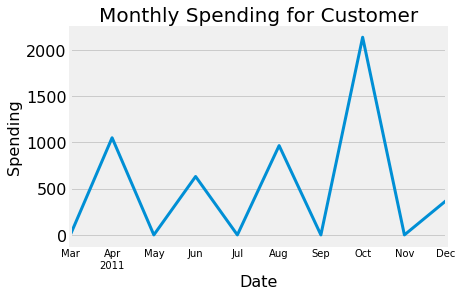

In [32]:
labels.loc[labels['CustomerID'] == 12347].set_index('cutoff_time')['total'].plot(figsize = (6,4), linewidth = 3)
plt.xlabel('Date', size = 16)
plt.ylabel('Spending', size = 16)
plt.title('Monthly Spending for Customer', size =20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

## Feature Tools Implementation

In [33]:
#Create an entityset that will hold all the data and the relationships between the multiple tables
data_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175,False
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325,False
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625,False


In [34]:
es = ft.EntitySet(id = 'Online Retail Logs')

#Add the entire data table as an entity
es.entity_from_dataframe('purchases',
                         dataframe = data_2011,
                         index = 'purchases_index',
                         time_index = 'InvoiceDate',
                         variable_types = {'Description':ft.variable_types.Text})

es['purchases']

Entity: purchases
  Variables:
    purchases_index (dtype: index)
    InvoiceNo (dtype: categorical)
    StockCode (dtype: categorical)
    Quantity (dtype: numeric)
    InvoiceDate (dtype: datetime_time_index)
    UnitPrice (dtype: numeric)
    CustomerID (dtype: numeric)
    Country (dtype: categorical)
    total (dtype: numeric)
    cancelled (dtype: boolean)
    Description (dtype: text)
  Shape:
    (Rows: 375250, Columns: 11)

**Normalizing Entities** 
- In order to create new tables out of the original table, we can normalize this entity. This creates new tables by creating a uniquerow for every variable that we pass in, such as the customer or the product.

In [35]:
#create a new 'products' entity
es.normalize_entity(new_entity_id='products',
                    base_entity_id = 'purchases',
                    index = 'StockCode',
                    additional_variables = ['Description'])
es['products'].df.head()

,StockCode,Description,first_purchases_time
22386,22386,JUMBO BAG PINK POLKADOT,2011-01-04 10:00:00
21499,21499,BLUE POLKADOT WRAP,2011-01-04 10:00:00
21498,21498,RED RETROSPOT WRAP,2011-01-04 10:00:00
22379,22379,RECYCLING BAG RETROSPOT,2011-01-04 10:00:00
20718,20718,RED RETROSPOT SHOPPER BAG,2011-01-04 10:00:00


In [36]:
es['purchases']

Entity: purchases
  Variables:
    purchases_index (dtype: index)
    InvoiceNo (dtype: categorical)
    StockCode (dtype: id)
    Quantity (dtype: numeric)
    InvoiceDate (dtype: datetime_time_index)
    UnitPrice (dtype: numeric)
    CustomerID (dtype: numeric)
    Country (dtype: categorical)
    total (dtype: numeric)
    cancelled (dtype: boolean)
  Shape:
    (Rows: 375250, Columns: 10)

In [37]:
#create a new 'customers' entity based on the orders entity
es.normalize_entity(new_entity_id='customers',
                    base_entity_id = 'purchases',
                    index = 'CustomerID')

#create a new 'orders' entity
es.normalize_entity(new_entity_id='orders',
                    base_entity_id = 'purchases',
                    index = 'InvoiceNo',
                    additional_variables = ['Country','cancelled'])

es

Entityset: Online Retail Logs
  Entities:
    purchases [Rows: 375250, Columns: 8]
    products [Rows: 3612, Columns: 3]
    customers [Rows: 4244, Columns: 2]
    orders [Rows: 20482, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode
    purchases.CustomerID -> customers.CustomerID
    purchases.InvoiceNo -> orders.InvoiceNo

## **Deep Feature Synthesis**

- Having defined our entity and created the proper relationships, we can perform deep feature synthesis to generate 100 or 1000s of features. 
- Since our objective is to classify customer spending, we'll make features for
 each customer for each month.

In [38]:
labels.head()

,CustomerID,cutoff_time,total,label
0,13313.0,2011-03-01,0.000,0
1,18097.0,2011-03-01,0.000,0
2,16656.0,2011-03-01,589.248,1
3,16875.0,2011-03-01,0.000,0
4,13094.0,2011-03-01,115.434,0


In [39]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28133 entries, 0 to 4196
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   28133 non-null  float64       
 1   cutoff_time  28133 non-null  datetime64[ns]
 2   total        28133 non-null  float64       
 3   label        28133 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.1 MB


In [40]:
labels.rename(columns={'cutoff_time':'time'}, inplace =True)

In [41]:
es

Entityset: Online Retail Logs
  Entities:
    purchases [Rows: 375250, Columns: 8]
    products [Rows: 3612, Columns: 3]
    customers [Rows: 4244, Columns: 2]
    orders [Rows: 20482, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode
    purchases.CustomerID -> customers.CustomerID
    purchases.InvoiceNo -> orders.InvoiceNo

In [42]:
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'customers', cutoff_time = labels,
                                       verbose = 2, cutoff_time_in_index= True, chunk_size = len(labels), n_jobs = -1,max_depth = 1)

feature_matrix.head()

Built 27 features
EntitySet scattered to 2 workers in 10 seconds
Elapsed: 00:29 | Progress: 100%|██████████


,,COUNT(purchases),MAX(purchases.Quantity),MAX(purchases.UnitPrice),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.UnitPrice),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.UnitPrice),MIN(purchases.total),...,STD(purchases.total),SUM(purchases.Quantity),SUM(purchases.UnitPrice),SUM(purchases.total),DAY(first_purchases_time),MONTH(first_purchases_time),WEEKDAY(first_purchases_time),YEAR(first_purchases_time),total,label
CustomerID,time,,,,,,,,,,,,,,,,,,,,,
13313.0,2011-03-01,17,25,7.0125,58.410,10.058824,3.692118,29.826176,4,0.6930,17.3250,...,11.998083,171,62.7660,507.0450,4,1,1,2011,0.000,0
18097.0,2011-03-01,9,60,16.4175,143.550,30.000000,4.882167,87.021000,6,0.6930,33.2640,...,41.359375,270,43.9395,783.1890,4,1,1,2011,0.000,0
16656.0,2011-03-01,14,216,14.0250,498.960,56.285714,5.079643,109.184036,-12,0.6930,-32.6700,...,144.361356,788,71.1150,1528.5765,4,1,1,2011,589.248,1
16875.0,2011-03-01,52,24,27.9675,65.670,7.250000,7.433250,24.218192,-8,0.4785,-16.4175,...,17.671397,377,386.5290,1259.3460,4,1,1,2011,0.000,0
13094.0,2011-03-01,3,72,1.7490,125.928,72.000000,1.749000,125.928000,72,1.7490,125.9280,...,0.000000,216,5.2470,377.7840,4,1,1,2011,115.434,0


- We dropthe total and labels columns before training as they were passed through from cutoff time data. Also drop Mode of the stock code and invoice number as it will not be usedfor creating features since they are index variables.

In [43]:
feature_matrix = feature_matrix.drop(columns = ['MODE(purchases.StockCode)','MODE(purchases.InvoiceNo)'])
feature_matrix.shape

(28133, 27)

In [44]:
feature_matrix.loc[12347,:].sample(10, axis = 1)

,NUM_UNIQUE(purchases.StockCode),STD(purchases.UnitPrice),DAY(first_purchases_time),SKEW(purchases.total),STD(purchases.Quantity),SUM(purchases.Quantity),MAX(purchases.total),MIN(purchases.UnitPrice),SKEW(purchases.UnitPrice),NUM_UNIQUE(purchases.InvoiceNo)
time,,,,,,,,,,
2011-03-01,29,4.015815,26,1.643541,7.510584,315,63.1125,0.6930,2.731972,1
2011-04-01,29,4.015815,26,1.643541,7.510584,315,63.1125,0.6930,2.731972,1
2011-05-01,46,4.088012,26,6.796760,32.387922,798,411.8400,0.4125,2.677160,2
2011-06-01,46,4.088012,26,6.796760,32.387922,798,411.8400,0.4125,2.677160,2
2011-07-01,58,3.954557,26,7.450736,28.279725,994,411.8400,0.4125,2.462034,3
2011-08-01,58,3.954557,26,7.450736,28.279725,994,411.8400,0.4125,2.462034,3
2011-09-01,65,4.128061,26,6.472880,25.078283,1271,411.8400,0.4125,2.331698,4
2011-10-01,65,4.128061,26,6.472880,25.078283,1271,411.8400,0.4125,2.331698,4
2011-11-01,83,4.019489,26,5.781226,21.064101,1947,411.8400,0.4125,2.384943,5


Text(0, 0.5, 'Purchases Per Customer')

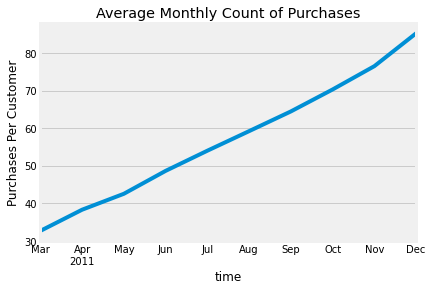

In [45]:
feature_matrix.groupby('time')['COUNT(purchases)'].mean().plot()
plt.title('Average Monthly Count of Purchases')
plt.ylabel('Purchases Per Customer')

- As we progress through time, we have more purchases per customer to use for prediction

Text(0, 0.5, 'Total Purchased Products Per Customer')

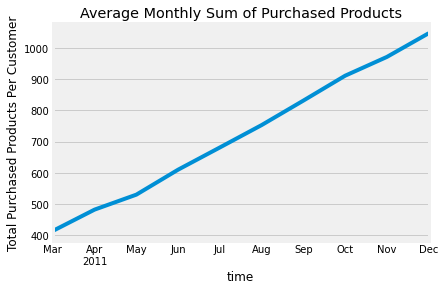

In [46]:
feature_matrix.groupby('time')['SUM(purchases.Quantity)'].mean().plot()
plt.title('Average Monthly Sum of Purchased Products')
plt.ylabel('Total Purchased Products Per Customer')

- As we include moe information, our forecasts should improve in accuracy.

## **Correlations**

In [47]:
feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(28133, 29)

In [48]:
corrs = feature_matrix.corr().sort_values('total')
corrs['total'].head()

MONTH(first_purchases_time)     -0.083372
DAY(first_purchases_time)       -0.050790
MIN(purchases.total)            -0.026663
WEEKDAY(first_purchases_time)   -0.009223
MIN(purchases.UnitPrice)        -0.006407
Name: total, dtype: float64

In [49]:
corrs['total'].dropna().tail()

label                              0.343661
NUM_UNIQUE(purchases.InvoiceNo)    0.351811
SUM(purchases.Quantity)            0.566804
SUM(purchases.total)               0.630549
total                              1.000000
Name: total, dtype: float64

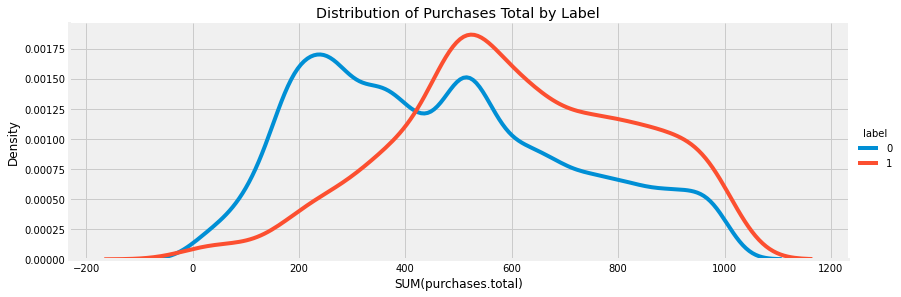

In [50]:
g = sns.FacetGrid(feature_matrix[(feature_matrix['SUM(purchases.total)']>0)&(feature_matrix['SUM(purchases.total)']<1000)],
                  hue = 'label', size = 4, aspect= 3)
g.map(sns.kdeplot, 'SUM(purchases.total)')
g.add_legend()
plt.title('Distribution of Purchases Total by Label')
plt.show()

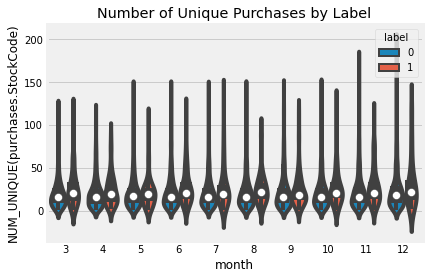

In [51]:
feature_matrix['month'] = feature_matrix['time'].dt.month
sns.violinplot(x = 'month', y = 'NUM_UNIQUE(purchases.StockCode)', hue = 'label', figsize=(24,6),
               data = feature_matrix[(feature_matrix['SUM(purchases.total)']>0) &(feature_matrix['SUM(purchases.total)']<1000)])
plt.title('Number of Unique Purchases by Label')
plt.show()

## **Preliminary Modelling**

- We will use Random forest for modelling, we will increase the number of trees to 1000 and keep other hyperparameters at default.

In [52]:
model = RandomForestClassifier(n_estimators = 1000,
                               random_state = 50,
                               n_jobs = -1)

In [53]:
from sklearn.pipeline import Pipeline

In [55]:
def predict_month(month, feature_matrix, return_probs = False):
  """Train and test a machine learning model using a feature set for one month.
  Testing labesl are from the month"""

  feature_matrix ['month']= feature_matrix['time'].dt.month

  #subset labels
  test_labels =feature_matrix.loc[feature_matrix['month'] == month,'label'] 
  train_labels =feature_matrix.loc[feature_matrix['month'] < month,'label'] 

  #features
  X_train = feature_matrix[feature_matrix['time'].dt.month < month].drop(columns = ['CustomerID','time','month','label','total'])
  X_test = feature_matrix[feature_matrix['time'].dt.month == month].drop(columns = ['CustomerID','time','month','label','total'])

  feature_names = list(X_train.columns)

  #Impute and scale features
  pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')),('scaler', MinMaxScaler())])

  #fit and transform training data
  X_train = pipeline.fit_transform(X_train)
  X_test = pipeline.transform(X_test)

  #labels
  y_train = np.array(train_labels).reshape((-1,))
  y_test = np.array(test_labels).reshape((-1,))

  print('Training on {} observations'.format(len(X_train)))
  print('Testing on {} observations.\n'.format(len(X_test)))

  #Train
  model.fit(X_train, y_train)

  #Make Predictions
  predictions  =model.predict(X_test)
  probs = model.predict_proba(X_test)[:,1]

  #Calculate metrics
  p = precision_score(y_test, predictions)
  r = recall_score(y_test, predictions)
  f = f1_score(y_test, predictions)
  auc = roc_auc_score(y_test, probs)

  print(f'Precision: {round(p,5)}')
  print(f'Recall: {round(r,5)}')
  print(f'F1 Score: {round(f,5)}')
  print(f'ROC AUC: {round(auc,5)}')

  #feature importance
  fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

  if return_probs:
    return fi, probs

  return fi


In [56]:
june_fi = predict_month(6, feature_matrix)

Training on 5266 observations
Testing on 2489 observations.

Precision: 0.55519
Recall: 0.40141
F1 Score: 0.46594
ROC AUC: 0.7488


In [59]:
def plot_feature_importances(df, n=15, threshold = None):
  "Plots n most important features"
  'Sort feature with most important at the head'
  df= df.sort_values('importance', ascending = False).reset_index(drop = True)

  #Normalize the feature importance to ass up to one and calculate cumulative importance
  df['importance_normalized'] = df['importance'] / df['importance'].sum()
  df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

  plt.rcParams['font.size'] = 12

  #Bar plot of n most important features
  df.loc[:n, :].plot.barh(y = 'importance_normalized',
                          x = 'feature', color = 'blue',
                          edgecolor = 'k', figsize=(12,8),
                          legend = False)
  plt.xlabel('Normalized Importance', size  =18); plt.ylabel('');
  plt.title(f'Top{n} Most Important Features',size = 18)
  plt.gca().invert_yaxis()

  if threshold:
    #Cummulative importance plot
    plt.figure(figsize= (8,6))
    plt.plot(list(range(len(df))), df['cumulative_mportance'], 'b-')
    plt.xlabel('Number of Features', size= 16)
    plt.ylabel('Cumulative Importance', size= 16)
    plt.title('Cumulative Feature Importance', size = 18)

    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))

    #Add vertical line to plot
    plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
    print('{} features required for {:.0f}% of cumulative importance'.format(importance_index + 1, 100*threshold))
  return df

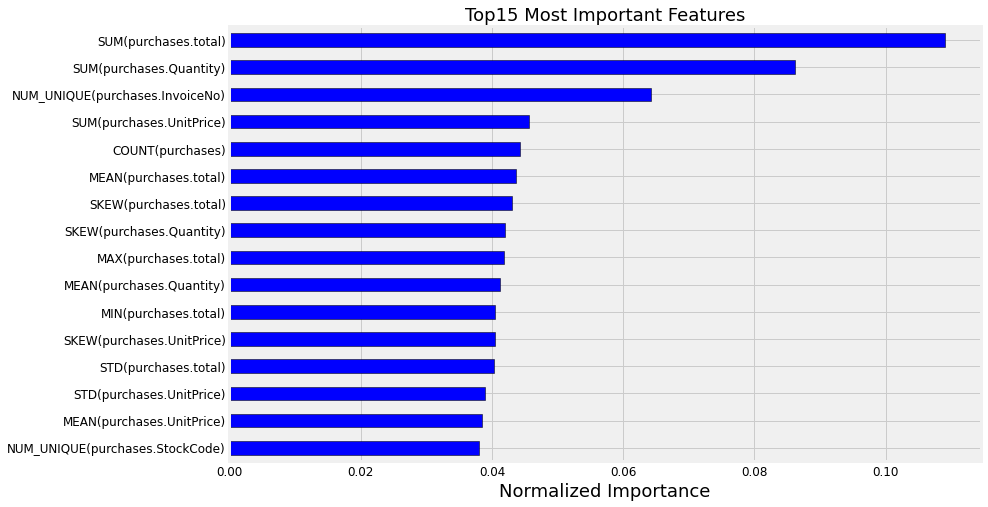

In [60]:
#Plot feature importance using this function
norm_june_fi = plot_feature_importances(june_fi)

## **Comparison to Baseline**

How is our model perfoming as compared to the baseline model (to the guesswork)?
We will use the amount spent by the customer in the last to predict whether he will spend more than the threshold of 500 usd or not in the coming month.

In [61]:
labels.head()

,CustomerID,time,total,label
0,13313.0,2011-03-01,0.000,0
1,18097.0,2011-03-01,0.000,0
2,16656.0,2011-03-01,589.248,1
3,16875.0,2011-03-01,0.000,0
4,13094.0,2011-03-01,115.434,0


In [67]:
#Try this with the month of July
labels['month'] = labels['time'].dt.month
july_labels = labels[labels['month'] == 7]
june_labels = labels[labels['month'] == 6]

july_labels = july_labels.rename(columns = {'total':'july_total'})
june_labels = june_labels.rename(columns = {'total':'june_total'})

#Merge the current month with the previous month
july_labels = july_labels.merge(june_labels[['CustomerID', 'june_total']], on = 'CustomerID', how = 'left')
july_labels['june_total'] = july_labels['june_total'].fillna(0)
july_labels['predicted_label'] = (july_labels['june_total']> 500).astype(int)

july_labels['probability'] = july_labels['june_total']/500

#Set the probabilities that are greater than 1 to be equal to 1

july_labels.loc[july_labels['probability'] > 1,'probability'] = 1

july_labels.sample(10, random_state = 50)



,CustomerID,time,july_total,label,month,june_total,predicted_label,probability
1647,14711.0,2011-07-01,0.0000,0,7,778.8165,1,1.00000
627,14849.0,2011-07-01,1342.9185,1,7,1624.8210,1,1.00000
2434,13213.0,2011-07-01,0.0000,0,7,221.2650,0,0.44253
2236,15258.0,2011-07-01,0.0000,0,7,507.3750,1,1.00000
1852,14747.0,2011-07-01,0.0000,0,7,0.0000,0,0.00000
1547,13946.0,2011-07-01,0.0000,0,7,0.0000,0,0.00000
241,13004.0,2011-07-01,508.9260,1,7,1121.6040,1,1.00000
437,13982.0,2011-07-01,0.0000,0,7,520.8060,1,1.00000
2043,14323.0,2011-07-01,0.0000,0,7,-29.2050,0,-0.05841
1972,17827.0,2011-07-01,0.0000,0,7,0.0000,0,0.00000


In [68]:
#Test correlation between spending in last month and current month
july_labels['july_total'].corr(july_labels['june_total'])

0.6212795006643788

There is moderate correlation between spending form one month to the next

Text(0.5, 1.0, 'July vs June Spending')

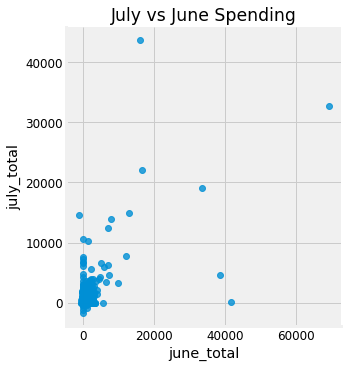

In [69]:
sns.lmplot('june_total', 'july_total', data = july_labels, fit_reg = False)
plt.title('July vs June Spending')

In [70]:
print('Precision:{:.5f}.'.format(precision_score(july_labels['label'],july_labels['predicted_label'])))
print('Recall:{:.5f}.'.format(recall_score(july_labels['label'],july_labels['predicted_label'])))
print('F1 Score:{:.5f}.'.format(f1_score(july_labels['label'],july_labels['predicted_label'])))
print('ROC AUC Score:{:.5f}.'.format(roc_auc_score(july_labels['label'],july_labels['probability'])))

Precision:0.41784.
Recall:0.39644.
F1 Score:0.40686.
ROC AUC Score:0.64355.


We can now compare this perfomance to that from the model

In [71]:
july_fi, july_probs = predict_month(7, feature_matrix, True)

Training on 7755 observations
Testing on 2752 observations.

Precision: 0.53191
Recall: 0.33408
F1 Score: 0.4104
ROC AUC: 0.75889


For a classifier, the most important parameter is the ROC AUC. To ensure our model is outperfoming the baseline, we can plt the ROC curves for the two outputs

Text(0.5, 1.0, 'ROC Curves')

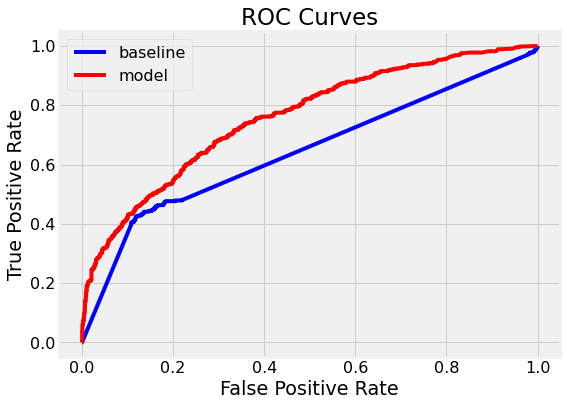

In [72]:
#Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(july_labels['label'], july_labels['probability'])
model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['month'] == 7]['label'],july_probs)

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 16

#Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')


- Based on this curves output, we can confirm that our machine learning model yield a better predicition than our baseline model.

In [80]:
def informed_baseline(month_number, threshold = 500):
    """Calculate an informed baseline for a given month. 
    The informed baseline is guessing the previous month's spending
    for the next month. The probability is assessed by dividing
    the previous month's total by the threshold and setting
    any values greater than 1 to 1."""
    
    # Subset to the months
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    # Merge the current month with the previous month
    month = month.merge(previous_month[['CustomerID', 'previous_total']], on = 'CustomerID', how = 'left')
    
    # For customers who had no spending in the previous month, set their spending to 0
    month['previous_total'] = month['previous_total'].fillna(0)
    
    # Calculate a probability based on the previous months spending and the threshold
    month['probability'] = month['previous_total'] / threshold
    
    # Set probabilities greater than 1 equal to 1
    month.loc[month['probability'] > 1, 'probability'] = 1
    
    # Make the predicted label
    month['prediction'] = (month['previous_total'] > threshold).astype(int)
    
    # Calculate metrics
    print('Precision: {:.5f}.'.format(precision_score(month['label'], month['prediction'])))
    print('Recall: {:.5f}.'.format(recall_score(month['label'], month['prediction'])))
    print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
    print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['probability'])))
    
    return month

In [81]:
#Compare a machine learning model trained on a set of features to the informaed baseline

def compare(month, feature_matrix):
  print('Baseline Perfomance')
  baseline = informed_baseline(month)

  print('\nModel Perfomance')
  fi, probs = predict_month(month, feature_matrix, return_probs= True)

  #Calculate false postive rates and true positive rates
  base_fpr, base_tpr, _ = roc_curve(baseline['label'], baseline['probability'])
  model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['month'] == month]['label'],probs)

  plt.figure(figsize=(8,6))
  plt.rcParams['font.size'] = 16

  #Plot both curves
  plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
  plt.plot(model_fpr, model_tpr, 'r', label = 'model')
  plt.legend()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')

Baseline Perfomance
Precision: 0.41201.
Recall: 0.46714.
F1 Score: 0.43784.
ROC AUC Score: 0.67322.

Model Perfomance
Training on 5266 observations
Testing on 2489 observations.

Precision: 0.55519
Recall: 0.40141
F1 Score: 0.46594
ROC AUC: 0.7488


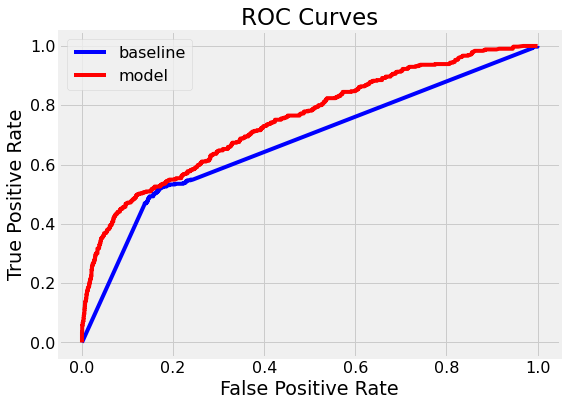

In [82]:
compare(6, feature_matrix)

We can now test for December, where we expect the best results because the model has trained on the most data

Baseline Perfomance
Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.69498.

Model Perfomance
Training on 23936 observations
Testing on 4197 observations.

Precision: 0.30977
Recall: 0.46855
F1 Score: 0.37297
ROC AUC: 0.79344


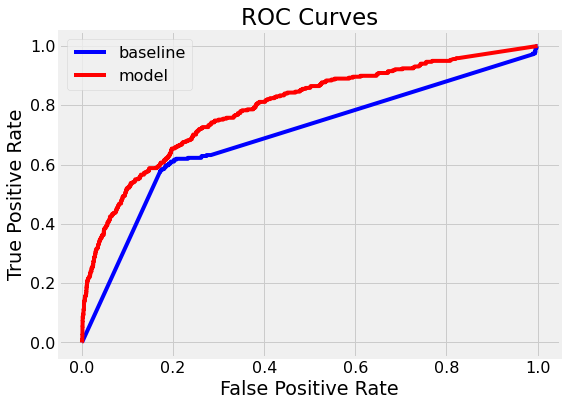

In [83]:
compare(12, feature_matrix)

- We get a slightly better ROC. Probably because of inconsistency in the data caused by seasonality in consumer behaviour.

## **Precision Recall Curve**

- Our model was running on a default threshold of 0.5.
- We can use the precision recall curve to identify the ideal threshold for our model. This is beacuase we may care more for accuracy than precision and vice versa.

In [88]:
def precision_recall(month, feature_matrix):
  'Show the precision vs recall curve for a month'

  #Find the probability
  fi, probs = predict_month(month, feature_matrix, return_probs = True)

  #Calculate metrics across thresholds
  precision, recall,t = precision_recall_curve(labels.loc[labels['time'].dt.month == month, 'label'], probs)

  #Plot the curve
  plt.step(recall, precision, color = 'b', alpha = 0.5, where ='post')

  #Fill in the curve
  plt.fill_between(recall, precision, step = 'post', alpha = 0.5, color = 'b')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.05])
  plt.title('Precision vs. Recall Curve')
  plt.show()


Training on 23936 observations
Testing on 4197 observations.

Precision: 0.30977
Recall: 0.46855
F1 Score: 0.37297
ROC AUC: 0.79344


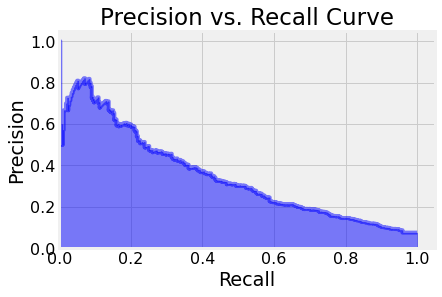

In [89]:
precision_recall(12, feature_matrix)

Training on 16631 observations
Testing on 3467 observations.

Precision: 0.50833
Recall: 0.29048
F1 Score: 0.3697
ROC AUC: 0.72216


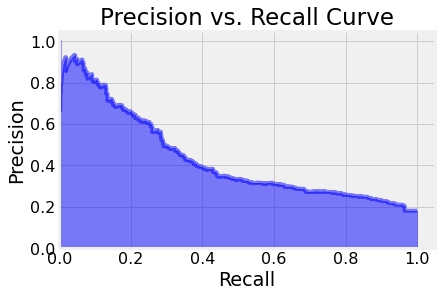

In [90]:
precision_recall(10, feature_matrix)

In [91]:
%%capture

#Record probabilities for each month
for month in range(4,13):
  _, probs = predict_month(month, feature_matrix, return_probs = True)
  temp_df = pd.DataFrame({'Automated':probs, 'month':month})

  if month == 4:
    probs_df = temp_df.copy()

  else:
    probs_df = probs_df.append(temp_df)

In [92]:
probs_df.head()

,Automated,month
0,0.029,4
1,0.104,4
2,0.943,4
3,0.184,4
4,0.297,4


In [93]:
probs_df.shape

(26851, 2)

In [94]:
probs_df['month'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12])

## **Conclusions**

- Feature tools automated feature engineering in an ML pipeline results in better prediction of future customer behavior than an informed baseline model.
- Feature tools helps to handle the issue of filtering data in a time series problem.